### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

#### Imports and Dataset

In [1]:
import numpy as np
import torch
from torchvision.datasets import MNIST, CIFAR10, Imagenette
from torch.utils.data import Subset, DataLoader
from torchvision.models import ResNet18_Weights
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
from dataclasses import dataclass
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
from torchvision import models
from tqdm import tqdm
import os

In [15]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

ds_train = MNIST(root='./data', train=True, download=True, transform=transform)
ds_test = MNIST(root='./data', train=False, download=True, transform=transform)

val_size = 5000
I = np.random.permutation(len(ds_train))
ds_val = Subset(ds_train, I[:val_size])
ds_train = Subset(ds_train, I[val_size:])

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


#### MLP e Configuration

In [17]:
@dataclass
class Config:
    batch_size: int = 128
    learning_rate: float = 1e-3
    epochs: int = 10
    hidden_layer_sizes: list = None
    log_dir: str = "runs/mnist_mlp_experiment"
    device: torch.device = device
    input_size: int = 28*28
    num_classes: int = 10
    activation_class: type = nn.ReLU   
    name: str = None                   

class MLP(nn.Module):
    def __init__(self, input_size, hidden_layer_sizes, num_classes, activation_class=nn.ReLU):
        super().__init__()
        layers = [nn.Flatten()]

        for hidden_layer_size in hidden_layer_sizes:
            layers.append(nn.Linear(input_size, hidden_layer_size))
            layers.append(activation_class())
            input_size = hidden_layer_size

        layers.append(nn.Linear(input_size, num_classes))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

#### Training utilities

In [19]:
def train_one_epoch(model, dataloader, optimizer, criterion, device, epoch=None):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    loop = tqdm(dataloader, desc=f"Epoch {epoch+1}" if epoch is not None else "Train", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        running_corrects += (preds == labels).sum().item()
        total_samples += labels.size(0)

        loop.set_postfix(loss=running_loss/total_samples, acc=running_corrects/total_samples)

    average_loss = running_loss / total_samples
    accuracy = running_corrects / total_samples
    return average_loss, accuracy


def evaluate(model, dataloader, criterion, device, split_name="Test"):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    loop = tqdm(dataloader, desc=split_name, leave=False)
    with torch.no_grad():
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            running_corrects += (preds == labels).sum().item()
            total_samples += labels.size(0)

            loop.set_postfix(loss=running_loss/total_samples, acc=running_corrects/total_samples)

    average_loss = running_loss / total_samples
    accuracy = running_corrects / total_samples
    return average_loss, accuracy


def assign_name(config):
    config.name = f"MLP_{'-'.join(map(str, config.hidden_layer_sizes))}"
    return config


In [20]:
def run_experiments(configs):
    results = []

    for config in configs:
        config = assign_name(config)
        print(f"\nRunning experiment: {config.name}")

        train_loader = torch.utils.data.DataLoader(ds_train, batch_size=config.batch_size, shuffle=True)
        test_loader  = torch.utils.data.DataLoader(ds_test, batch_size=config.batch_size, shuffle=False)

        model = MLP(input_size=config.input_size,
                    hidden_layer_sizes=config.hidden_layer_sizes,
                    num_classes=config.num_classes,
                    activation_class=config.activation_class).to(config.device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
        writer = SummaryWriter(log_dir=f"{config.log_dir}/{config.name}")

        best_test_acc = 0.0
        best_epoch = 0

        for epoch in range(config.epochs):
            train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, config.device, epoch)
            test_loss, test_acc = evaluate(model, test_loader, criterion, config.device, split_name="Test")

            writer.add_scalar("Loss/train", train_loss, epoch)
            writer.add_scalar("Accuracy/train", train_acc, epoch)
            writer.add_scalar("Loss/test", test_loss, epoch)
            writer.add_scalar("Accuracy/test", test_acc, epoch)

            if test_acc > best_test_acc:
                best_test_acc = test_acc
                best_epoch = epoch + 1  

        writer.close()

        print(f"Model {config.name} | Best Test Acc: {best_test_acc:.4f} reached at epoch {best_epoch}")

        results.append({
            "model": config.name,
            "best_test_acc": best_test_acc,
            "best_epoch": best_epoch
        })

    df = pd.DataFrame(results)
    print("\nSummary of best test accuracies per model")
    print(df)
    return df

In [21]:
configs = [
    Config(hidden_layer_sizes=[16,16], epochs=11),
    Config(hidden_layer_sizes=[64,32,16], epochs=11),
    Config(hidden_layer_sizes=[256,128], epochs=11),
]

summary_df = run_experiments(configs)


Running experiment: MLP_16-16


Model MLP_16-16 | Best Test Acc: 0.9541 reached at epoch 11

Running experiment: MLP_64-32-16


Model MLP_64-32-16 | Best Test Acc: 0.9712 reached at epoch 11

Running experiment: MLP_256-128


Model MLP_256-128 | Best Test Acc: 0.9816 reached at epoch 10

Summary of best test accuracies per model
          model  best_test_acc  best_epoch
0     MLP_16-16         0.9541          11
1  MLP_64-32-16         0.9712          11
2   MLP_256-128         0.9816          10


### Exercise 1.2: Adding Residual Connections

Implement a variant of your parameterized MLP network to support **residual** connections. Your network should be defined as a composition of **residual MLP** blocks that have one or more linear layers and add a skip connection from the block input to the output of the final linear layer.

**Compare** the performance (in training/validation loss and test accuracy) of your MLP and ResidualMLP for a range of depths. Verify that deeper networks **with** residual connections are easier to train than a network of the same depth **without** residual connections.

**For extra style points**: See if you can explain by analyzing the gradient magnitudes on a single training batch *why* this is the case. 

In [29]:
class ResidualMLPBlock(nn.Module):
    def __init__(self, hidden_size, num_layers=2, activation_class=nn.ReLU):
        super().__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(activation_class())
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.block(x)   

    
class ResidualMLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_blocks, num_layers_per_block=2, num_classes=10, activation_class=nn.ReLU):
        super().__init__()
        self.flatten = nn.Flatten()
        self.input_layer = nn.Linear(input_size, hidden_size)

        blocks = []
        for _ in range(num_blocks):
            blocks.append(ResidualMLPBlock(hidden_size, num_layers_per_block, activation_class))
        self.blocks = nn.Sequential(*blocks)

        self.output_layer = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.input_layer(x)   
        x = self.blocks(x)
        return self.output_layer(x)

#### Expand Config and run_experiments to include the ResidualMLP

In [37]:
@dataclass
class Config:
    batch_size: int = 128
    learning_rate: float = 0.0001
    epochs: int = 10
    log_dir: str = "runs/mnist_mlp_residual_experiment"
    device: torch.device = device
    input_size: int = 28*28
    num_classes: int = 10
    activation_class: type = nn.ReLU
    name: str = None

    # previous MLP 
    hidden_layer_sizes: list = None 

    # for ResidualMLP
    hidden_size: int = None
    num_blocks: int = None
    num_layers_per_block: int = 1
    
def assign_name(config, model_type="MLP"):
    if model_type == "MLP":
        depth = len(config.hidden_layer_sizes)
        first_size = config.hidden_layer_sizes[0] if depth > 0 else "None"
        config.name = f"MLP_{first_size}x{depth}"  # e.g., MLP_16x16
    elif model_type == "ResidualMLP":
        config.name = f"ResMLP_hidden{config.hidden_size}_blocks{config.num_blocks}_layersPerBlock{config.num_layers_per_block}"
    return config

def run_experiments(configs, model_class=MLP, model_type="MLP"):
    results = []

    for config in configs:
        config = assign_name(config, model_type=model_type)
        print(f"\nRunning experiment: {config.name}")

        train_loader = torch.utils.data.DataLoader(ds_train, batch_size=config.batch_size, shuffle=True)
        test_loader  = torch.utils.data.DataLoader(ds_test, batch_size=config.batch_size, shuffle=False)

        if model_type == "MLP":
            model = model_class(
                input_size=config.input_size,
                hidden_layer_sizes=config.hidden_layer_sizes,
                num_classes=config.num_classes,
                activation_class=config.activation_class
            ).to(config.device)
        elif model_type == "ResidualMLP":
            model = model_class(
                input_size=config.input_size,
                hidden_size=config.hidden_size,
                num_blocks=config.num_blocks,
                num_layers_per_block=config.num_layers_per_block,
                num_classes=config.num_classes,
                activation_class=config.activation_class
            ).to(config.device)
        else:
            raise ValueError(f"Unknown model_type: {model_type}")

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
        writer = SummaryWriter(log_dir=f"{config.log_dir}/{config.name}")

        best_test_acc = 0.0
        best_epoch = 0

        for epoch in range(config.epochs):
            train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, config.device, epoch)
            test_loss, test_acc = evaluate(model, test_loader, criterion, config.device, split_name="Test")

            writer.add_scalar("Loss/train", train_loss, epoch)
            writer.add_scalar("Accuracy/train", train_acc, epoch)
            writer.add_scalar("Loss/test", test_loss, epoch)
            writer.add_scalar("Accuracy/test", test_acc, epoch)

            if test_acc > best_test_acc:
                best_test_acc = test_acc
                best_epoch = epoch + 1  

        writer.close()

        print(f"Model {config.name} | Best Test Acc: {best_test_acc:.4f} reached at epoch {best_epoch}")

        results.append({
            "model": config.name,
            "best_test_acc": best_test_acc,
            "best_epoch": best_epoch
        })

    df = pd.DataFrame(results)
    print("\nSummary of best test accuracies per model")
    print(df)
    return df


In [38]:
configs_mlp = [
    Config(hidden_layer_sizes=[16]*2, epochs=21),
    Config(hidden_layer_sizes=[16]*8, epochs=21),
    Config(hidden_layer_sizes=[16]*32, epochs=21),
    Config(hidden_layer_sizes=[16]*64, epochs=21),
]

configs_residual = [
    Config(hidden_size=16, num_blocks=2, num_layers_per_block=1, epochs=21),
    Config(hidden_size=16, num_blocks=8, num_layers_per_block=1, epochs=21),
    Config(hidden_size=16, num_blocks=32, num_layers_per_block=1, epochs=21),
    Config(hidden_size=16, num_blocks=64, num_layers_per_block=1, epochs=21),
]

In [39]:
summary_mlp = run_experiments(configs_mlp, model_class=MLP, model_type="MLP")
summary_residual = run_experiments(configs_residual, model_class=ResidualMLP, model_type="ResidualMLP")


Running experiment: MLP_16x2


Model MLP_16x2 | Best Test Acc: 0.9316 reached at epoch 21

Running experiment: MLP_16x8


Model MLP_16x8 | Best Test Acc: 0.8767 reached at epoch 21

Running experiment: MLP_16x32


Model MLP_16x32 | Best Test Acc: 0.1135 reached at epoch 3

Running experiment: MLP_16x64


Model MLP_16x64 | Best Test Acc: 0.1135 reached at epoch 2

Summary of best test accuracies per model
       model  best_test_acc  best_epoch
0   MLP_16x2         0.9316          21
1   MLP_16x8         0.8767          21
2  MLP_16x32         0.1135           3
3  MLP_16x64         0.1135           2

Running experiment: ResMLP_hidden16_blocks2_layersPerBlock1


Model ResMLP_hidden16_blocks2_layersPerBlock1 | Best Test Acc: 0.9400 reached at epoch 21

Running experiment: ResMLP_hidden16_blocks8_layersPerBlock1


Model ResMLP_hidden16_blocks8_layersPerBlock1 | Best Test Acc: 0.9527 reached at epoch 21

Running experiment: ResMLP_hidden16_blocks32_layersPerBlock1


Model ResMLP_hidden16_blocks32_layersPerBlock1 | Best Test Acc: 0.9462 reached at epoch 21

Running experiment: ResMLP_hidden16_blocks64_layersPerBlock1


Model ResMLP_hidden16_blocks64_layersPerBlock1 | Best Test Acc: 0.3560 reached at epoch 21

Summary of best test accuracies per model
                                      model  best_test_acc  best_epoch
0   ResMLP_hidden16_blocks2_layersPerBlock1         0.9400          21
1   ResMLP_hidden16_blocks8_layersPerBlock1         0.9527          21
2  ResMLP_hidden16_blocks32_layersPerBlock1         0.9462          21
3  ResMLP_hidden16_blocks64_layersPerBlock1         0.3560          21


#### Check sensitivity to changes in the n of layer inside the residual blocks

In [43]:
# (for a fair comparison num_blocks are halved)

configs_residual = [
    Config(hidden_size=16, num_blocks=1, num_layers_per_block=2, epochs=21, log_dir= "runs/mnist_mlp_residual_2_layers_per_block"),
    Config(hidden_size=16, num_blocks=4, num_layers_per_block=2, epochs=21, log_dir= "runs/mnist_mlp_residual_2_layers_per_block"),
    Config(hidden_size=16, num_blocks=16, num_layers_per_block=2, epochs=21, log_dir= "runs/mnist_mlp_residual_2_layers_per_block"),
    Config(hidden_size=16, num_blocks=32, num_layers_per_block=2, epochs=21, log_dir= "runs/mnist_mlp_residual_2_layers_per_block"),
]
summary_residual = run_experiments(configs_residual, model_class=ResidualMLP, model_type="ResidualMLP")


Running experiment: ResMLP_hidden16_blocks1_layersPerBlock2


Model ResMLP_hidden16_blocks1_layersPerBlock2 | Best Test Acc: 0.9338 reached at epoch 21

Running experiment: ResMLP_hidden16_blocks4_layersPerBlock2


Model ResMLP_hidden16_blocks4_layersPerBlock2 | Best Test Acc: 0.9489 reached at epoch 20

Running experiment: ResMLP_hidden16_blocks16_layersPerBlock2


Model ResMLP_hidden16_blocks16_layersPerBlock2 | Best Test Acc: 0.9592 reached at epoch 21

Running experiment: ResMLP_hidden16_blocks32_layersPerBlock2


Model ResMLP_hidden16_blocks32_layersPerBlock2 | Best Test Acc: 0.9619 reached at epoch 21

Summary of best test accuracies per model
                                      model  best_test_acc  best_epoch
0   ResMLP_hidden16_blocks1_layersPerBlock2         0.9338          21
1   ResMLP_hidden16_blocks4_layersPerBlock2         0.9489          20
2  ResMLP_hidden16_blocks16_layersPerBlock2         0.9592          21
3  ResMLP_hidden16_blocks32_layersPerBlock2         0.9619          21


### Note the imrovment of the deeper MLP from 36% accuracy to 96%

### Check gradients

In [77]:
def get_grad_norms(model):
    grad_norms = []
    for p in model.parameters():
        if p.grad is None:
            continue
        grad = p.grad.detach().cpu()
        norm = (grad * grad).sum().sqrt().item()
        grad_norms.append(norm)
    return grad_norms

### Check on single batch

In [78]:
train_loader = torch.utils.data.DataLoader(ds_train, batch_size=128, shuffle=True)
x_batch, y_batch = next(iter(train_loader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

criterion = nn.CrossEntropyLoss()

mlp_model = MLP(
    input_size=28*28,
    hidden_layer_sizes=[16]*32,
    num_classes=10,
    activation_class=nn.ReLU
).to(device)

residual_model = ResidualMLP(
    input_size=28*28,
    hidden_size=16,
    num_blocks=32,
    num_layers_per_block=1,
    num_classes=10,
    activation_class=nn.ReLU
).to(device)

In [79]:
mlp_model.zero_grad()
output = mlp_model(x_batch)
loss = criterion(output, y_batch)
loss.backward()
mlp_grad_norms = get_grad_norms(mlp_model)


residual_model.zero_grad()
output = residual_model(x_batch)
loss = criterion(output, y_batch)
loss.backward()
res_grad_norms = get_grad_norms(residual_model)

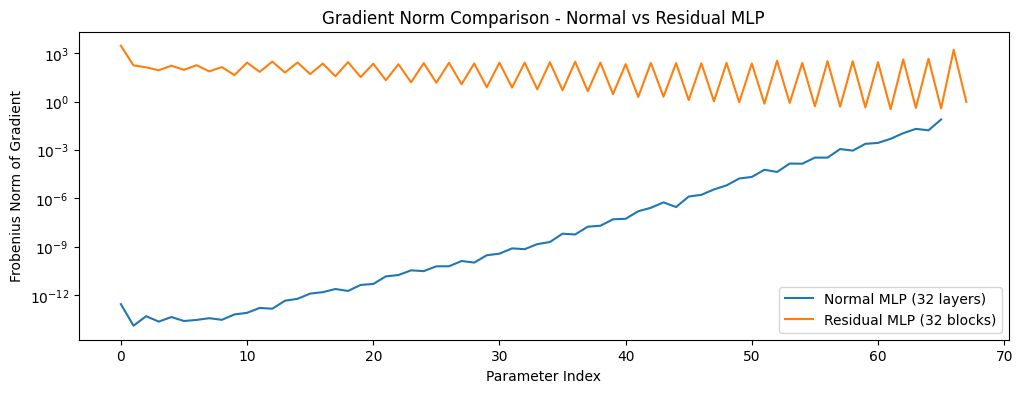

In [80]:
plt.figure(figsize=(12, 4))
plt.plot(mlp_grad_norms)
plt.plot(res_grad_norms)
plt.xlabel('Parameter Index')
plt.ylabel('Frobenius Norm of Gradient')
plt.yscale('log')
plt.legend(['Normal MLP (32 layers)', 'Residual MLP (32 blocks)'])
plt.title('Gradient Norm Comparison - Normal vs Residual MLP')
plt.show()

### (This zig-zag is expected and reflects the difference between weight and bias gradients)

### Exercise 1.3: Rinse and Repeat (but with a CNN)

In [77]:
transform_cifar10 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

ds_train = CIFAR10(root='./data', train=True, download=True, transform=transform_cifar10)
ds_test  = CIFAR10(root='./data', train=False, download=True, transform=transform_cifar10)

In [80]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, skip_connection=True):
        super().__init__()
        self.skip_connection = skip_connection

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        out = self.block(x)
        if self.skip_connection:
            out += self.shortcut(x)
        out = F.relu(out)
        return out


class CNN(nn.Module):
    """CNN with optional residual connections."""
    def __init__(self, num_blocks, num_classes=10, channels=3, skip_connection=True):
        super().__init__()
        self.in_channels = 64
        self.skip_connection = skip_connection

        self.conv = nn.Sequential(
            nn.Conv2d(channels, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        self.layers = nn.Sequential(
            self._make_layer(ResidualBlock, 64, num_blocks[0], stride=1, skip_connection=skip_connection),
            self._make_layer(ResidualBlock, 128, num_blocks[1], stride=2, skip_connection=skip_connection),
            self._make_layer(ResidualBlock, 256, num_blocks[2], stride=2, skip_connection=skip_connection),
            self._make_layer(ResidualBlock, 512, num_blocks[3], stride=2, skip_connection=skip_connection),
        )

        self.pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride, skip_connection=True):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for s in strides:
            layers.append(block(self.in_channels, out_channels, stride=s, skip_connection=skip_connection))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv(x)
        x = self.layers(x)
        x = self.pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [193]:
@dataclass
class CNNConfig:
    batch_size: int = 128
    learning_rate: float = 1e-3
    epochs: int = 20
    log_dir: str = "runs/cifar_cnn_experiment"
    device: torch.device = device
    num_classes: int = 10
    name: str = None

    num_blocks: list = None
    skip_connection: bool = True


def assign_name(config):
    suffix = "residual" if config.skip_connection else "plain"
    config.name = f"CNN_{'-'.join(map(str, config.num_blocks))}_{suffix}"
    return config


In [194]:
def run_experiments_cnn(configs, save_models=True):
    results = []
    if save_models:
        os.makedirs("models_weights", exist_ok=True)

    for config in configs:
        config = assign_name(config)
        print(f"\nRunning experiment: {config.name}")

        train_loader = DataLoader(ds_train, batch_size=config.batch_size, shuffle=True)
        test_loader  = DataLoader(ds_test, batch_size=config.batch_size, shuffle=False)

        model = CNN(
            num_blocks=config.num_blocks,
            num_classes=config.num_classes,
            skip_connection=config.skip_connection
        ).to(config.device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
        writer = SummaryWriter(log_dir=f"{config.log_dir}/{config.name}")

        best_test_acc = 0.0
        best_epoch = 0

        for epoch in range(config.epochs):
            train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, config.device, epoch)
            test_loss, test_acc = evaluate(model, test_loader, criterion, config.device, split_name="Test")

            writer.add_scalar("Loss/train", train_loss, epoch)
            writer.add_scalar("Accuracy/train", train_acc, epoch)
            writer.add_scalar("Loss/test", test_loss, epoch)
            writer.add_scalar("Accuracy/test", test_acc, epoch)

            if test_acc > best_test_acc:
                best_test_acc = test_acc
                best_epoch = epoch + 1
                if save_models:
                    save_path = os.path.join("models_weights", f"{config.name}.pt")
                    torch.save(model.state_dict(), save_path)

        writer.close()
        print(f"Model {config.name} | Best Test Acc: {best_test_acc:.4f} at epoch {best_epoch}")

        results.append({
            "model": config.name,
            "best_test_acc": best_test_acc,
            "best_epoch": best_epoch
        })

    df = pd.DataFrame(results)
    print("\nSummary of best test accuracies per model")
    print(df)
    return df

In [195]:
configs_cnn = [
    CNNConfig(num_blocks=[2,2,2,2], epochs=21, skip_connection=True),    
    CNNConfig(num_blocks=[2,2,2,2], epochs=21, skip_connection=False),   
    CNNConfig(num_blocks=[3,4,6,3], epochs=21, skip_connection=True),    
    CNNConfig(num_blocks=[3,4,6,3], epochs=21, skip_connection=False),  
]


In [197]:
summary_cnn = run_experiments_cnn(configs_cnn, save_models=True)


Running experiment: CNN_2-2-2-2_residual


Model CNN_2-2-2-2_residual | Best Test Acc: 0.8471 at epoch 14

Running experiment: CNN_2-2-2-2_plain


Model CNN_2-2-2-2_plain | Best Test Acc: 0.8515 at epoch 21

Running experiment: CNN_3-4-6-3_residual


Model CNN_3-4-6-3_residual | Best Test Acc: 0.8503 at epoch 20

Running experiment: CNN_3-4-6-3_plain


Model CNN_3-4-6-3_plain | Best Test Acc: 0.8137 at epoch 21

Summary of best test accuracies per model
                  model  best_test_acc  best_epoch
0  CNN_2-2-2-2_residual         0.8471          14
1     CNN_2-2-2-2_plain         0.8515          21
2  CNN_3-4-6-3_residual         0.8503          20
3     CNN_3-4-6-3_plain         0.8137          21


### Exercise 2.3: *Explain* the predictions of a CNN

In [85]:
classes = ds_test.classes  

seed = 2222
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [86]:
model_path = "models_weights/CNN_3-4-6-3_residual.pt"
model = CNN(num_blocks=[3,4,6,3], num_classes=10, skip_connection=True).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

indices = random.sample(range(len(ds_test)), 6)
images, labels = zip(*[ds_test[i] for i in indices])

In [3]:
def grab_features(layer, images, model, device):
    saved_features = []

    def _grab(module, input, output):
        saved_features.append(output.detach())

    hook = layer.register_forward_hook(_grab)
    model.eval()
    _ = model(torch.stack(images).to(device))
    hook.remove()

    return saved_features[0]


def make_cam(feature_map, classifier_weights, class_index):
    weights = classifier_weights[class_index]   
    cam = torch.sum(weights[:, None, None] * feature_map, dim=0)
    cam = np.maximum(cam.cpu().numpy(), 0)
    cam_norm = cv2.normalize(cam, None, 0, 1, cv2.NORM_MINMAX)
    return cam_norm


def overlay_cam(image_tensor, cam, alpha=0.45):
    img = image_tensor.permute(1,2,0).cpu().numpy()
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.247, 0.243, 0.261])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255*cam_resized), cv2.COLORMAP_JET)
    heatmap = heatmap[..., ::-1] / 255.0  # BGR -> RGB

    overlay = alpha * heatmap + (1-alpha) * img
    overlay = np.clip(overlay, 0, 1)
    return img, overlay


In [88]:
last_conv_layer = model.layers[-1][-1]

feature_maps = grab_features(last_conv_layer, images, model, device)

classifier_weights = model.fc.weight.data

inputs = torch.stack(images).to(device)
outputs = model(inputs)
_, preds = torch.max(outputs, 1)


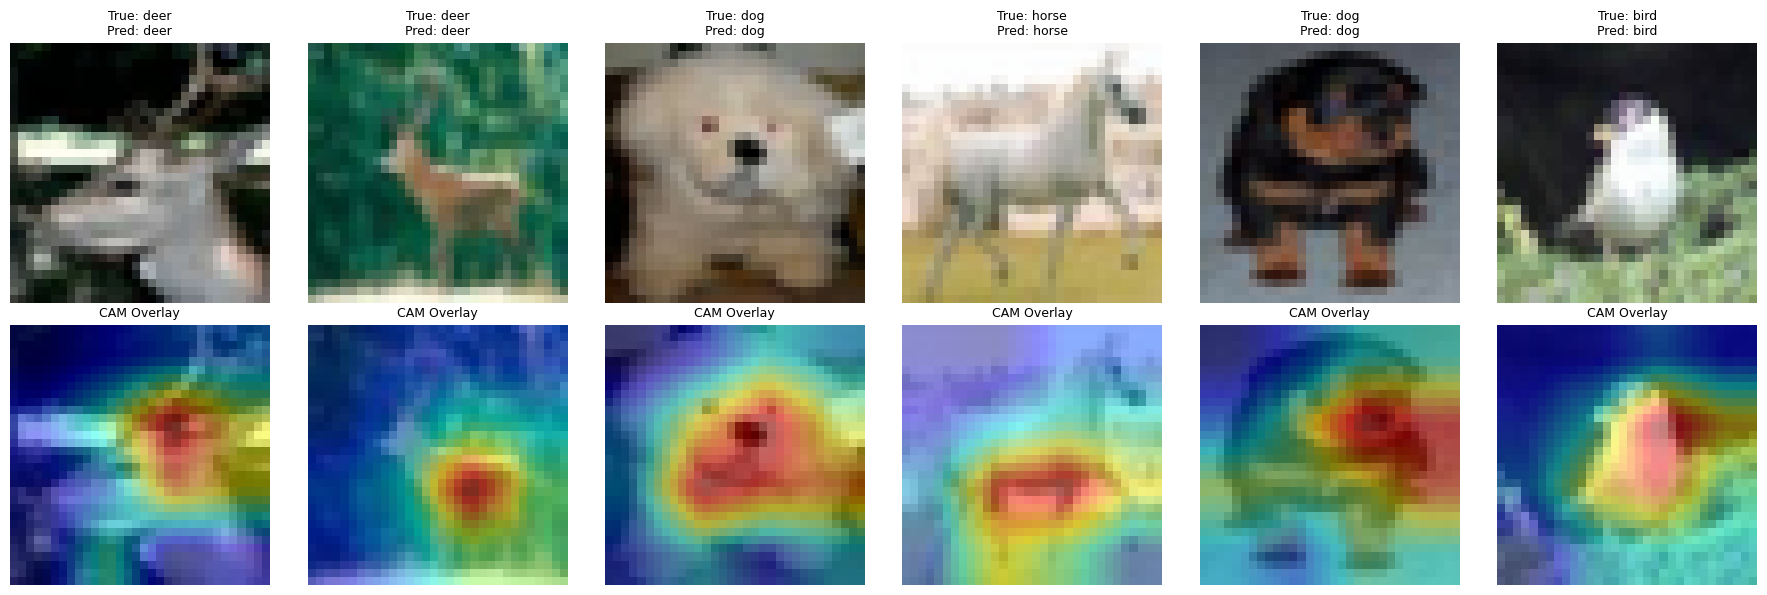

Saved figure: cifar10_cam_6images.png


In [89]:
fig, axes = plt.subplots(2, 6, figsize=(18, 6), facecolor='white')

for i, img_tensor in enumerate(images):
    cam = make_cam(feature_maps[i], classifier_weights, preds[i].item())
    img, overlay = overlay_cam(img_tensor, cam, alpha=0.45)

    ax = axes[0, i]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"True: {classes[labels[i]]}\nPred: {classes[preds[i]]}", fontsize=9)

    ax = axes[1, i]
    ax.imshow(overlay)
    ax.axis('off')
    ax.set_title("CAM Overlay", fontsize=9)

plt.tight_layout()

save_path = "cifar10_cam_6images.png"
fig.savefig(save_path)
plt.show()
print(f"Saved figure: {save_path}")

#### CAM with pretrained ResNet18 (on Imagenette)

In [4]:
transform = transforms.Compose([
    transforms.Resize(160),
    transforms.CenterCrop(160),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = Imagenette(root='./data', split='val', download=True, transform=transform)

In [15]:
imagenet_classes = ResNet18_Weights.IMAGENET1K_V1.meta["categories"] 
indices = random.sample(range(len(dataset)), 6)
images, labels = zip(*[dataset[i] for i in indices])

In [16]:
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
last_conv_layer = model.layer4[-1].conv2
feature_maps = grab_features(last_conv_layer, images, model, device)
classifier_weights = model.fc.weight.data

inputs = torch.stack(images).to(device)
outputs = model(inputs)
_, preds = torch.max(outputs, 1)

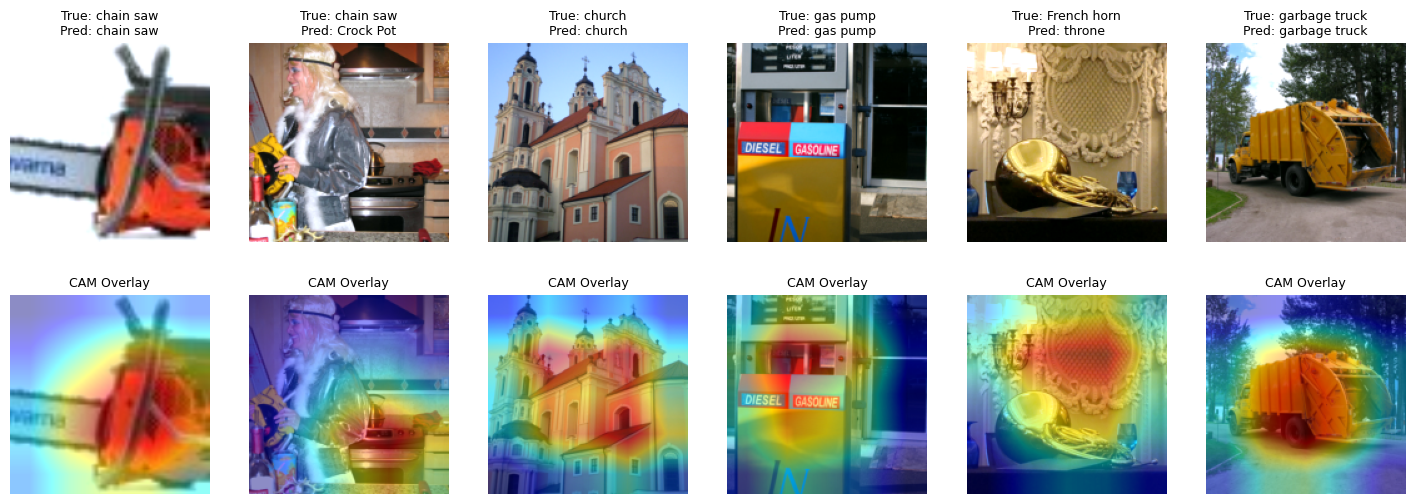

Saved figure: imagenette_cam_6images.png


In [18]:
fig, axes = plt.subplots(2, 6, figsize=(18, 6), facecolor='white')

for i in range(6):
    cam = make_cam(feature_maps[i], classifier_weights, preds[i].item())
    img, overlay = overlay_cam(images[i], cam, alpha=0.45)

    true_label = dataset.classes[labels[i]][0]
    pred_label = imagenet_classes[preds[i].item()]

    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=9)

    axes[1, i].imshow(overlay)
    axes[1, i].axis('off')
    axes[1, i].set_title("CAM Overlay", fontsize=9)

save_path = "imagenette_cam_6images.png"
fig.savefig(save_path)
plt.show()
print(f"Saved figure: {save_path}")